In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, time, random, keras, pickle, gc
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, load_model, Model
from face_verification.facenet import train_triplet_generator
from face_verification.facenet import test_triplet_generator

%matplotlib inline

Using TensorFlow backend.


# Load Image Data

In [2]:
vgg2_train = pd.read_csv('./images/vgg2_train_path.csv')
vgg2_test = pd.read_csv('./images/vgg2_test_path.csv')

print('Train:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_train['name'].unique()), 
                                                           len(vgg2_train)))
print('Test:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_test['name'].unique()),
                                                          len(vgg2_test)))

vgg2_train.head()

Train:	# person = 8631	 # images = 2113881
Test:	# person =  500	 # images =  116568


,name,path
0,n000002,./images/vgg2_face/train/n000002/0054_01.jpg
1,n000002,./images/vgg2_face/train/n000002/0029_01.jpg
2,n000002,./images/vgg2_face/train/n000002/0202_02.jpg
3,n000002,./images/vgg2_face/train/n000002/0037_01.jpg
4,n000002,./images/vgg2_face/train/n000002/0046_01.jpg


In [3]:
# pre-process the train and test dataframe
def path_to_list(df):
    """ function to merge df into the name and path list format """
    paths = list(df['path'].values)
    count = len(paths)
    
    return pd.Series([count, paths], index=['count', 'paths'])

In [4]:
vgg2_train_df = vgg2_train.groupby('name').apply(path_to_list).reset_index()
vgg2_test_df = vgg2_test.groupby('name').apply(path_to_list).reset_index()

vgg2_train_df.head()

,name,count,paths
0,n000002,198,"[./images/vgg2_face/train/n000002/0054_01.jpg,..."
1,n000003,143,"[./images/vgg2_face/train/n000003/0054_01.jpg,..."
2,n000004,334,"[./images/vgg2_face/train/n000004/0054_01.jpg,..."
3,n000005,67,"[./images/vgg2_face/train/n000005/0430_02.jpg,..."
4,n000006,374,"[./images/vgg2_face/train/n000006/0154_01.jpg,..."


# Load Pre-trained Models

### I. Margin 0.1

### II. Margin 0.2

In [6]:
# define training and test dataset image generator
loops = 10
test_generator = test_triplet_generator(vgg2_test_df, batch_size=100, loops=loops, seed=42)

# read test images
size = loops * 500
anchor_imgs = np.zeros((size, 96, 96, 3))
positive_imgs = np.zeros((size, 96, 96, 3))
negative_imgs = np.zeros((size, 96, 96, 3))

for i in range(size // 100):
    images, labels = next(test_generator)
    anchor_imgs[i*100: (i+1)*100] = images[0]
    positive_imgs[i*100: (i+1)*100] = images[1]
    negative_imgs[i*100: (i+1)*100] = images[2]

In [8]:
# load pre-trained model
filepath = './models/margin-02-20180801-0231/facenet-model.h5'
model = load_model(filepath=filepath, custom_objects={'tf': tf})

# make predictions
anchor_vec = model.predict(anchor_imgs)
positive_vec = model.predict(positive_imgs)
negative_vec = model.predict(negative_imgs)

# calcualte the distance
pair_distance = np.sqrt(np.sum(np.square(positive_vec - anchor_vec), axis=1))
diff_distance = np.sqrt(np.sum(np.square(negative_vec - anchor_vec), axis=1))

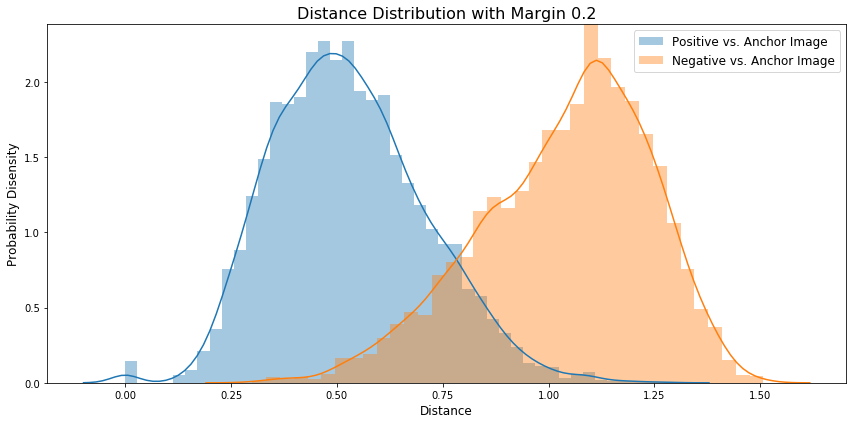

In [15]:
# visualization
fig, ax = plt.subplots(figsize=(12, 6))
sns.distplot(pair_distance, label='Positive vs. Anchor Image', ax=ax)
sns.distplot(diff_distance, label='Negative vs. Anchor Image', ax=ax)
ax.set_title('Distance Distribution with Margin 0.2', fontsize=16)
ax.set_xlabel('Distance', fontsize=12)
ax.set_ylabel('Probability Disensity', fontsize=12)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

### III. Margin 0.3

### IV. Margin 0.4

### V. Margin 0.5